In [1]:
import numpy as np
import poke.poke_core as pol
import poke.plotting as plot
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
import poppy


In [2]:
pth = 'Subaru_M1-M3_750nm.fits'

jones_pupil = fits.open(pth)[0].data

# Reclaim the complex numbers from the fits file ;-;
J11 = jones_pupil[:,:,0,0,0] + 1j*jones_pupil[:,:,0,0,1] 
J12 = jones_pupil[:,:,0,1,0] + 1j*jones_pupil[:,:,0,1,1]

J21 = jones_pupil[:,:,1,0,0] + 1j*jones_pupil[:,:,1,0,1] 
J22 = jones_pupil[:,:,1,1,0] + 1j*jones_pupil[:,:,1,1,1]

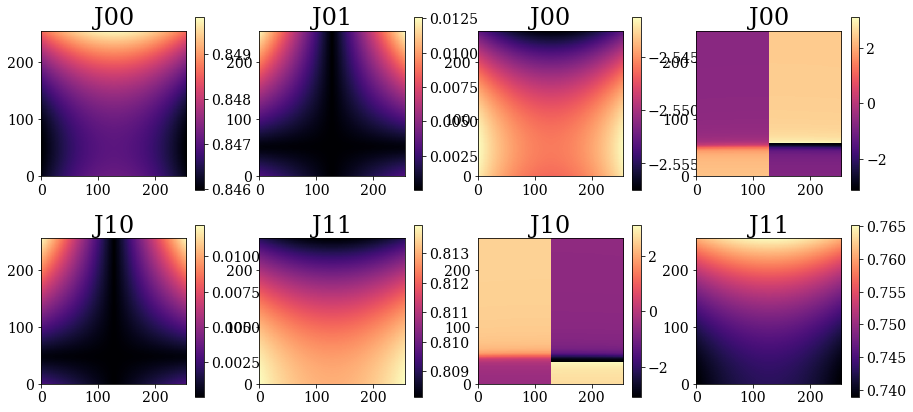

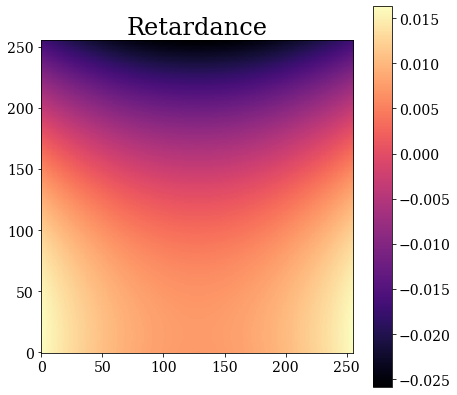

In [3]:
plot.PlotJonesArray(J11,J12,J21,J22)

ret = np.angle(J11)-np.angle(J22)
ret -= np.mean(ret)

plt.figure(figsize=[7,7])
plt.title('Retardance')
plt.imshow(ret)
plt.colorbar()
plt.show()

In [4]:
# Define some input linear polarization state
E = np.array([1,1,0])/np.sqrt(2)
# E /= np.linalg.norm(E) # Make sure that we don't violate conservation of energy

wl = 750e-9*u.m 
npix = 256*u.pix
diam = 8.2*u.m 
pixelscale = diam/npix
os = 8

# Make Jones Array Optical Elements
def MakeArrayOpticalElement(jxx,wl,pixscal):

    trans = np.abs(jxx)
    opd = np.angle(jxx) * wl/(2*np.pi)

    optic = poppy.ArrayOpticalElement(transmission=trans,opd=opd,pixelscale=pixscal)

    return optic 

def MakeMeanOpticalElement(jxx,wl,pixscal):

    trans = np.abs(jxx)
    trans_mean = np.mean(trans)
    trans = trans*0 + trans_mean

    opd = np.angle(jxx) * wl/(2*np.pi)
    opd_mean = np.mean(opd)
    opd = opd*0 # no aberration allowed

    optic = poppy.ArrayOpticalElement(transmission=trans,opd=opd,pixelscale=pixscal)

    return optic 

j11 = MakeArrayOpticalElement(J11,wl,pixelscale)
j12 = MakeArrayOpticalElement(J12,wl,pixelscale)
j21 = MakeArrayOpticalElement(J21,wl,pixelscale)
j22 = MakeArrayOpticalElement(J22,wl,pixelscale)

j11_mean = MakeMeanOpticalElement(J11,wl,pixelscale)
j12_mean = MakeMeanOpticalElement(J12,wl,pixelscale)
j21_mean = MakeMeanOpticalElement(J21,wl,pixelscale)
j22_mean = MakeMeanOpticalElement(J22,wl,pixelscale)

def PropagateToFocus(jxx):

    # load pupil
    pupil_pth = 'scexao_pupil.fits'
    pupil_data = fits.open(pupil_pth)[0].data

    pupil = poppy.ArrayOpticalElement(transmission=pupil_data,pixelscale=8.2*u.m/(pupil_data.shape[0]*u.pix))

    wf = poppy.FresnelWavefront(beam_radius=4.1*u.m,oversample=os,wavelength=750e-9*u.m)
    subaru_efl = 110.629*u.m
    osys = poppy.FresnelOpticalSystem()
    # osys.add_optic(poppy.CircularAperture(radius=4.1*u.m))
    osys.add_optic(pupil)
    osys.add_optic(jxx)
    osys.add_optic(poppy.QuadraticLens(subaru_efl))
    osys.add_optic(poppy.ScalarTransmission(),distance=subaru_efl)
    wfout = osys.propagate(wf)

    return wfout

psf_j11 = PropagateToFocus(j11)
psf_j12 = PropagateToFocus(j12)
psf_j21 = PropagateToFocus(j21)
psf_j22 = PropagateToFocus(j22)
psf_ref = PropagateToFocus(j11_mean)

After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8

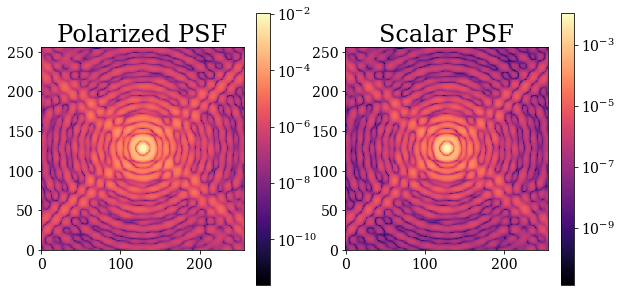

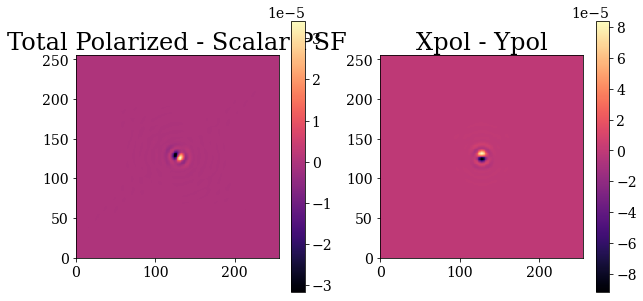

Difference =  [-0.01628082  0.03316367] marcsec / pix
Difference Pol =  [ 0.10027784 -0.00263559] marcsec / pix
Total Difference =  -0.011938298063853381 marcsec / pix


In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage.measurements import center_of_mass

subaru_efl = 110.629*u.m

def CropCenter(array,cut):

    dim = array.shape[0]
    array_out = array[int(dim/2 - cut):int(dim/2 + cut),int(dim/2 - cut):int(dim/2 + cut)]

    return array_out

j11_out = CropCenter(psf_j11.wavefront,128)
j12_out = CropCenter(psf_j12.wavefront,128)
j21_out = CropCenter(psf_j21.wavefront,128)
j22_out = CropCenter(psf_j22.wavefront,128)
ref_out = np.abs(CropCenter(psf_ref.wavefront,128))**2

xpol_out = np.abs(j11_out + j12_out)**2
ypol_out = np.abs(j21_out + j22_out)**2
xpol_out /= np.sum(xpol_out)
ypol_out /= np.sum(ypol_out)

pol_out = xpol_out + ypol_out 

just_j11 = np.abs(CropCenter(psf_j11.wavefront,128))**2

# normalize by input energy
ref_out /= np.sum(ref_out)
pol_out /= np.sum(pol_out)
j11_out /= np.sum(j11_out)

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Polarized PSF')
plt.imshow(pol_out,norm=LogNorm())
plt.colorbar()

plt.subplot(122)
plt.title('Scalar PSF')
plt.imshow(ref_out,norm=LogNorm())
plt.colorbar()
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Total Polarized - Scalar PSF')
plt.imshow(pol_out-ref_out)
plt.colorbar()

plt.subplot(122)
plt.title('Xpol - Ypol')
plt.imshow(xpol_out-ypol_out)
plt.colorbar()
plt.show()
com_nom = center_of_mass(ref_out)*psf_ref.pixelscale/subaru_efl*206265*1e3*u.marcsec
com_pol = center_of_mass(pol_out)*psf_ref.pixelscale/subaru_efl*206265*1e3*u.marcsec
total = np.sqrt(com_nom[0]**2 +com_nom[1]**2) - np.sqrt(com_pol[0]**2 +com_pol[1]**2)
xcom = center_of_mass(xpol_out)*psf_ref.pixelscale/subaru_efl*206265*1e3*u.marcsec
ycom = center_of_mass(ypol_out)*psf_ref.pixelscale/subaru_efl*206265*1e3*u.marcsec

print('Difference = ',(com_pol-com_nom))
print('Difference Pol = ',xcom-ycom)
print('Total Difference = ',total)

<Quantity 1.26481326e-06 m / pix>

In [ ]:
def PropagateMilesCoronagraph(jxx):

    # Two propagations to compute off-axis contrast

    # load pupil
    pupil_pth = 'scexao_pupil.fits'
    pupil_data = fits.open(pupil_pth)[0].data
    pupil = poppy.ArrayOpticalElement(transmission=pupil_data,pixelscale=8.2*u.m/(pupil_data.shape[0]*u.pix))

    # load lyot stop
    lyot_pth = 'lyot_stop_pupil.fits'
    lyot_data = fits.open(lyot_pth)[0].data
    lyot = poppy.ArrayOpticalElement(transmission=lyot_data,pixelscale=8.2*u.m/(lyot_data.shape[0]*u.pix))

    for i in range(2):
        wf = poppy.FresnelWavefront(beam_radius=4.1*u.m,oversample=os,wavelength=750e-9*u.m)
        subaru_efl = 110.629*u.m
        osys = poppy.FresnelOpticalSystem()
        if i == 0:
            osys.add_optic(poppy.ZernikeWFE(radius=4.1*u.m,coefficients=[0,750e-9]))
        osys.add_optic(pupil)
        osys.add_optic(jxx)
        osys.add_optic(poppy.QuadraticLens(subaru_efl),distance=subaru_efl)

        # Make a 2 L/D focal Plane Mask
        wl = 750e-9
        D = 8.2
        LonD = wl/D * subaru_efl # plate scale

        fpm = poppy.InverseTransmission(poppy.CircularAperture(name='fpm',radius = 1*LonD))
        osys.add_optic(fpm,distance=subaru_efl)
        osys.add_optic(poppy.QuadraticLens(subaru_efl),distance=subaru_efl)
        osys.add_optic(lyot,distance=subaru_efl)
        osys.add_optic(poppy.QuadraticLens(subaru_efl),distance=subaru_efl)
        osys.add_optic(poppy.ScalarTransmission(),distance=subaru_efl)

        wfout = osys.propagate(wf)

        if i == 0:
            peak_off_ax = np.max(np.abs(wfout.wavefront))
            wf = 0
            wfout = 0

    return wfout,peak_off_ax

def CreateMilesRefPSF(jxx):
    # load pupil
    pupil_pth = 'scexao_pupil.fits'
    pupil_data = fits.open(pupil_pth)[0].data
    pupil = poppy.ArrayOpticalElement(transmission=pupil_data,pixelscale=8.2*u.m/(pupil_data.shape[0]*u.pix))

    # load lyot stop
    lyot_pth = 'lyot_stop_pupil.fits'
    lyot_data = fits.open(lyot_pth)[0].data
    lyot = poppy.ArrayOpticalElement(transmission=lyot_data,pixelscale=8.2*u.m/(lyot_data.shape[0]*u.pix))

    wf = poppy.FresnelWavefront(beam_radius=4.1*u.m,oversample=os,wavelength=750e-9*u.m)
    subaru_efl = 110.629*u.m
    osys = poppy.FresnelOpticalSystem()
    osys.add_optic(pupil)
    osys.add_optic(jxx)
    osys.add_optic(poppy.QuadraticLens(subaru_efl),distance=subaru_efl)
    osys.add_optic(poppy.ScalarTransmission(),distance=subaru_efl)

    wf_out = osys.propagate(wf)

    return wf_out

In [ ]:
j11_coron,j11_peak = PropagateMilesCoronagraph(j11)
j12_coron,j12_peak = PropagateMilesCoronagraph(j12)
ref_coron,ref_peak = PropagateMilesCoronagraph(j11_mean)
# ref_psf = CreateMilesRefPSF()

After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8

In [6]:
# Crop the PSF
from matplotlib.patches import Circle 

# Configure Pixelscale in L/D
subaru_efl = 110.629
wl = 750e-9
D = 8.2
npix = 256
LonD = wl/D * subaru_efl # plate scale
pixelscale = D/j11_coron.wavefront.shape[0]
pix_fpm = int(pixelscale/LonD)
print(pix_fpm)

pol_wavefront = np.abs(j11_coron.wavefront+ j12_coron.wavefront)/(j11_peak + j12_peak)

j11_cropped = CropCenter(pol_wavefront,npix)
ref_cropped = CropCenter(np.abs(ref_coron.wavefront)/ref_peak,npix)


fig,ax = plot.subplots(nrows=1,ncols=3,figsize=[15,5])

ax[0].set_title('Polarized PSF')
circ = Circle((npix,npix),pix_fpm,fill=False,linestyle='--',edgecolor='white')
ax[0].add_patch(circ)
pol = ax[0].imshow(j11_cropped,norm=LogNorm())
fig.colorbar(pol,ax=ax[0])

ax[1].set_title('Scalar PSF')
circ = Circle((npix,npix),pix_fpm,fill=False,linestyle='--',edgecolor='white')
ax[1].add_patch(circ)
sca = ax[1].imshow(ref_cropped,norm=LogNorm())
fig.colorbar(sca,ax=ax[1])

ax[2].set_title('Difference PSF')
dif = ax[2].imshow(j11_cropped-ref_cropped)
fig.colorbar(dif,ax=ax[2])

plot.show()

NameError: name 'j11_coron' is not defined

NameError: name 'j11_cropped' is not defined

In [ ]:
pix_fpm

3165